In [2]:
import numpy as np
import pandas as pd
import pyod
import suod
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from suod.models.base import SUOD
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.pca import PCA
from sklearn.metrics import roc_auc_score

## Generating synthetic data

We are going to define as anomalies as samples that have been drawn from a different distribution than the rest of the population. Therefore we can create our labeled synthetic dataset by drawing most of our samples from a normal distribution and some of our samples from an exponential distribution. In most anomaly detection settings like in credit card fraud the data that are available are high dimensional. For that purpose we select our synthetic dataset to have 100 dimensions representing a person's profile or spending vector. At the same time the anomalous data points are scattered in the population and typically do not consist more than 5% of the population. From my experience this rate is even lower in real scenarios and it is not unreasonable to be way lower than 1% (black swans). 

In [3]:
dimensions = 100
mu = [50]*dimensions
cov = np.eye(dimensions)
# draw 1000 normal data points
normal_data = np.random.multivariate_normal(mu, cov, 1000) 
# draw 10 data points from exponential distribution
anomaly_data = np.random.exponential(scale=50, size=(10, 100))
dataset = np.concatenate((normal_data, anomaly_data))

In [4]:
# in order to visualise the data we will use TSNE for dimensionality reduction
tsne = TSNE(n_components=2)
dataset_2d = tsne.fit_transform(dataset)

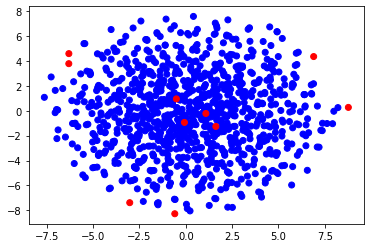

In [5]:
# let's visualise the data tif we could detect anomalies with an "eye" test
colors = ["blue"]*1000 + ["red"]*10
plt.scatter(x=dataset_2d[:,0], y=dataset_2d[:,1], c=colors)

# Modeling

Visually we can detect one point but we are missing the other ones. Apparently this approach is not great for detecting all the outliers but give us at least an idea if there are any. Let's see if we could do better with an enseble of outlier models form pyod. 

In [6]:
# Here we are "cheating" a bit since we know the contamination rate of 1% in our dataset
contamination = 0.01
# We consider 7 base estimators for our ensemble and 3 different algorithms. For ensembles
# it is a common practice to include the same algorithms with different configurations.
base_estimators = [
    LOF(n_neighbors=5, contamination=contamination),
    LOF(n_neighbors=15, contamination=contamination),
    LOF(n_neighbors=25, contamination=contamination),
    PCA(contamination=contamination),
    KNN(n_neighbors=5, contamination=contamination),
    KNN(n_neighbors=15, contamination=contamination),
    KNN(n_neighbors=25, contamination=contamination)]

model = SUOD(base_estimators=base_estimators, n_jobs=6,  
             rp_flag_global=True,  
             bps_flag=True,  
             approx_flag_global=False, 
             contamination=contamination)

model.fit(dataset)  
model.approximate(dataset)  
predicted_labels = model.predict(dataset)

Worker 1 sum of ranks: 1.8571428571428572
Worker 2 sum of ranks: 1.8571428571428572
Worker 3 sum of ranks: 1.8571428571428572
Worker 4 sum of ranks: 2.571428571428571
Worker 5 sum of ranks: 2.857142857142857
Worker 6 sum of ranks: 0.0

Split among workers BPS: [0, 1, 2, 3, 5, 7, 7] [1, 1, 1, 2, 2, 0]
Parallel Training...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.9s remaining:    3.8s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    2.0s finished


Balanced Scheduling Total Train Time: 2.069896697998047
Split among workers default: [2 3 4 5 6 7] [1, 1, 1, 1, 1]


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.7s remaining:    3.5s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    1.7s finished


Worker 1 sum of ranks: 1.8571428571428572
Worker 2 sum of ranks: 1.8571428571428572
Worker 3 sum of ranks: 1.8571428571428572
Worker 4 sum of ranks: 2.571428571428571
Worker 5 sum of ranks: 2.857142857142857
Worker 6 sum of ranks: 0.0

Split among workers BPS: [0, 1, 2, 3, 5, 7, 7] [1, 1, 1, 2, 2, 0]


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.8s remaining:    3.6s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    2.0s finished


In [7]:
# As a result for each data point we have 7 predictions one for each model. At this
# point we consider each model a voter. Models vote for a data point to be an outlier
# or not. If the majority of the models predict that it is an outlier it is 
# labeled as such. If there are concrete labels the voters could have learnable weights.
voted_predictions = predicted_labels.sum(axis=1)
voted_labels = [1 if x>4 else 0 for x in voted_predictions]
true_labels = [0]*1000 + [1]*10
# As a metric we are using roc_auc_score since our dataset
# is heavily imbalanced. In anomaly detection the most common metrics
# are AUC in training and precision in testing.
auc_score = roc_auc_score(voted_labels, true_labels)
print("The resulted area under the ROC curve score is {}".format(auc_score))

The resulted area under the ROC curve score is 1.0


# Summary

In this notebook we were showcasing a toy use case of anomaly detection with a synthetic dataset. We visualised the data and leveraged an ensemble of outlier models to predict anomalies within the training dataset. If we wanted to - probably in the real world - we could save the model and call it when we need to identify if the data come from a normal distribution of 100 dimension with mu=50 and unit covariance.